In [3]:
#Importing the necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer, BertModel, DistilBertForSequenceClassification, AdamW, DistilBertTokenizer, BertForSequenceClassification, AutoModelForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

#Setting up the device
device = torch.device("mps") if torch.backends.mps.is_available() else (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)

print(device)

cuda


In [4]:
#Implementing Focal Loss to tackle the class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        """
        Parameters:
        - alpha: Class weights.
        - gamma: Focusing parameter to down-weight well-classified examples.
        - reduction: Specifies the reduction to apply to the output ('mean', 'sum', or 'none').
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Compute the focal loss.

        Args:
        - inputs: Predicted logits of shape (N, num_classes).
        - targets: Ground truth labels of shape (N,).

        Returns:
        - Loss value.
        """
        #Converting logits to probabilities using softmax
        probs = torch.softmax(inputs, dim=-1)

        #Gathering the predicted probabilities for the target class
        targets_one_hot = nn.functional.one_hot(targets, num_classes=inputs.size(-1))
        pt = (probs * targets_one_hot).sum(dim=-1)

        #Clamping to prevent numerical instability
        pt = pt.clamp(min=1e-8, max=1 - 1e-8)

        #Computing the modulating factor
        focal_weight = (1 - pt).pow(self.gamma)

        #Applying alpha (class weights)
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_weight = focal_weight * alpha_t

        #Computing the final loss
        loss = -focal_weight * torch.log(pt)

        #Reduction
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

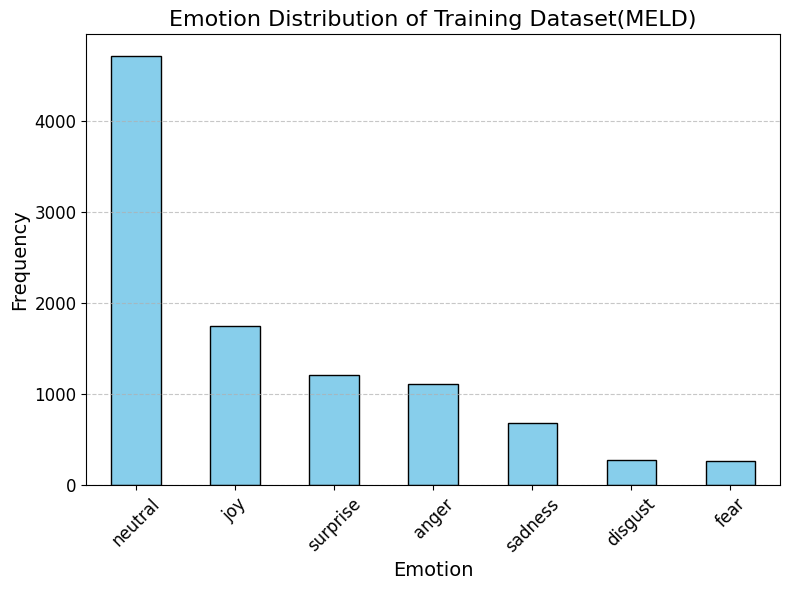

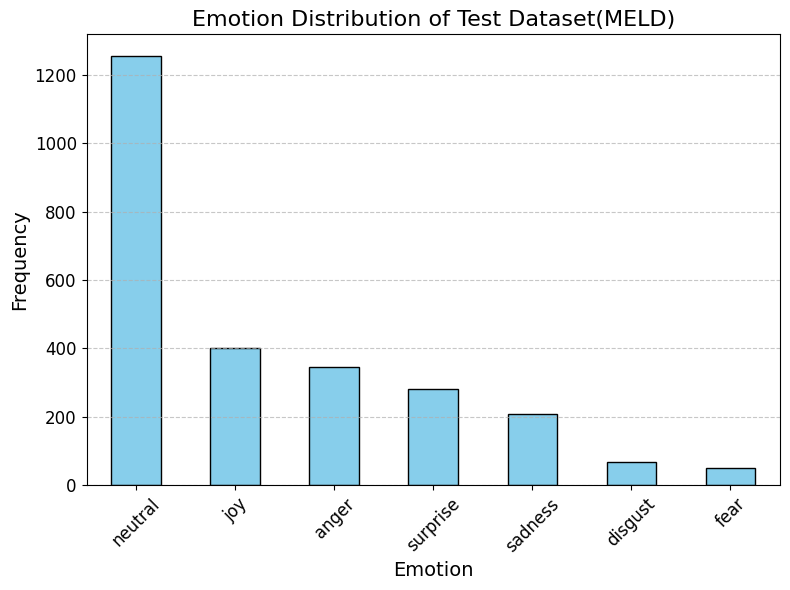

In [5]:
#Loading the Dataset

train_data = pd.read_csv('train_sent_emo.csv', encoding='utf-8')
test_data = pd.read_csv('test_sent_emo.csv', encoding='utf-8')

train_data = train_data.drop(columns=['Sr No.'])
train_data = train_data.dropna()


test_data = test_data.drop(columns=['Sr No.'])
test_data = test_data.dropna()

#Histograms of Train and Test Data
train_emotion_counts = train_data['Emotion'].value_counts()

plt.figure(figsize=(8, 6))
train_emotion_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Emotion Distribution of Training Dataset(MELD)', fontsize=16)
plt.xlabel('Emotion', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


test_emotion_counts = test_data['Emotion'].value_counts()

plt.figure(figsize=(8, 6))
test_emotion_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Emotion Distribution of Test Dataset(MELD)', fontsize=16)
plt.xlabel('Emotion', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [8]:
#Checking the class distribution
print(Counter(train_data['Emotion']))
print(Counter(test_data['Emotion']))

Counter({'joy': 1500, 'neutral': 1500, 'surprise': 1205, 'anger': 1109, 'sadness': 683, 'disgust': 271, 'fear': 268})
Counter({'anger': 150, 'joy': 150, 'neutral': 150, 'sadness': 150, 'surprise': 150, 'disgust': 68, 'fear': 50})


In [6]:
#Preparing the Dataset for Task A: Emotion Discovery

#Randomly select 1500 samples for each emotion
train_data = train_data.groupby('Emotion', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), 1500), random_state=42)
)

test_data = test_data.groupby('Emotion', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), 150), random_state=42)
)

print("Train Data Overview:")
print(train_data.head())
print("Test Data Overview:")
print(test_data.head())

#Useful when converting the text labels to int labels.
emotion_mapping = {
    'neutral': 0,
    'anger': 1,
    'disgust': 2,
    'fear': 3,
    'joy': 4,
    'sadness': 5,
    'surprise': 6
}

batch_size = 32

model_name = "distilbert-base-uncased"

tokenizer = DistilBertTokenizer.from_pretrained(model_name)

def calculate_max_length(dataframe, tokenizer):
    utterances = dataframe['Utterance'].tolist()
    max_length = 0
    longest_utterance = ""

    #Iterating through the utterances to find the maximum length and corresponding utterance
    for utterance in utterances:
        length = len(tokenizer(utterance, truncation=False, return_tensors="pt")['input_ids'][0])
        if length > max_length:
            max_length = length
            longest_utterance = utterance

    return max_length, longest_utterance

class SentenceDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.utterances = dataframe['Utterance'].tolist()
        self.labels = dataframe['Emotion'].map(emotion_mapping).tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.utterances)


    def __getitem__(self, idx):
        utterance = self.utterances[idx]
        label = self.labels[idx]
        label = max(0, min(label, num_classes - 1))

        #Tokenizing the utterances
        encoding = self.tokenizer(
            utterance,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

max_length, longest_utterance = calculate_max_length(train_data, tokenizer)
print(f"Longest Utterance: {longest_utterance}")
print(f"Max Length: {max_length}")

train_data_tokens = SentenceDataset(train_data, tokenizer, max_length)
test_data_tokens = SentenceDataset(test_data, tokenizer, max_length)

train_dataloader = DataLoader(train_data_tokens, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data_tokens, batch_size=batch_size, shuffle=False)

<ipython-input-6-9e72e02f6d94>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_data = train_data.groupby('Emotion', group_keys=False).apply(
<ipython-input-6-9e72e02f6d94>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_data = test_data.groupby('Emotion', group_keys=False).apply(


Train Data Overview:
                                              Utterance Speaker Emotion  \
8117                            What?!  What the hell?!  Phoebe   anger   
3109  Because I’m not going to spend one more day wi...    Jill   anger   
467   Come on apartment! Come on apartment!  Oh! I k...  Rachel   anger   
6549  And-and that’s only ‘cause it’s right there wh...    Joey   anger   
6725  No, no, no, don't! I've been waitin' for like,...    Joey   anger   

      Dialogue_ID  Utterance_ID  
8117          853             7  
3109          328             1  
467            46             6  
6549          679            14  
6725          704             1  
Test Data Overview:
                                              Utterance Speaker Emotion  \
1477  The only person that should feel awkward is yo...  Joanna   anger   
1096                                Are you mocking me?  Monica   anger   
1657                                      Yeah! Got it!    Ross   anger   
1538

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Longest Utterance: Um, ok, uh, oh god, um, when you and uh Ross first started going out, it was really hard for me, um, for many reasons, which I'm not gonna bore you with now, but um, I just, I see how happy he is, you know, and how good you guys are together, and um, Monica's always saying how nice you are, and god I hate it when she's right.
Max Length: 95


In [6]:
#Finding the alpha value for the Loss Function
labels = train_data['Emotion'].map(emotion_mapping).tolist()
classes = {'labels' : labels}
classes_df = pd.DataFrame(classes)
class_counts = classes_df['labels'].value_counts()
class_counts_dict = class_counts.sort_index().to_dict()

num_classes = len(class_counts_dict)
counts = [class_counts_dict.get(i, 0) for i in range(num_classes)]

class_counts_tensor = torch.tensor(counts, dtype=torch.float32)

alpha = 1.0 / class_counts_tensor
alpha = alpha / alpha.sum()
print(f"Alpha values: {alpha}")
alpha = alpha.to(device)

Alpha values: tensor([0.0558, 0.0755, 0.3088, 0.3122, 0.0558, 0.1225, 0.0694])


In [7]:
#Setting up the Model
class DistilBERTForClassification(torch.nn.Module):
    def __init__(self, model_name, num_classes):
        super(DistilBERTForClassification, self).__init__()
        self.distilbert = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits

In [8]:
class BERTForClassification(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTForClassification, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_token_embedding = outputs.last_hidden_state[:, 0, :]
        logits = self.fc(cls_token_embedding)
        return self.softmax(logits)

In [9]:
epochs = 10
num_classes = 7

model = DistilBERTForClassification(model_name, num_classes=7)

model.to(device)

optimizer = Adam(model.parameters(), lr=1e-5)
loss_fn = CrossEntropyLoss()
focal_loss = FocalLoss(alpha=alpha, gamma=3.0)

#Training Phase
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    # Training Phase
    model.train()
    train_loss = 0
    all_preds, all_labels = [], []

    train_bar = tqdm(train_dataloader, desc="Training")
    for batch in train_bar:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        #loss = loss_fn(outputs, labels)
        loss = focal_loss(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_dataloader)
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average="weighted")
    train_precision = precision_score(all_labels, all_preds, average="weighted")
    train_recall = recall_score(all_labels, all_preds, average="weighted")

    print(f"Train Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")



model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


Training: 100%|██████████| 205/205 [00:53<00:00,  3.80it/s, loss=0.0811]


Train Loss: 0.0977, Accuracy: 0.3599, F1: 0.3607, Precision: 0.3934, Recall: 0.3599
Epoch 2/10


Training: 100%|██████████| 205/205 [00:54<00:00,  3.75it/s, loss=0.103]


Train Loss: 0.0764, Accuracy: 0.5047, F1: 0.5153, Precision: 0.5340, Recall: 0.5047
Epoch 3/10


Training: 100%|██████████| 205/205 [00:54<00:00,  3.80it/s, loss=0.0747]


Train Loss: 0.0651, Accuracy: 0.5425, F1: 0.5522, Precision: 0.5782, Recall: 0.5425
Epoch 4/10


Training: 100%|██████████| 205/205 [00:56<00:00,  3.62it/s, loss=0.0473]


Train Loss: 0.0545, Accuracy: 0.5875, F1: 0.5934, Precision: 0.6147, Recall: 0.5875
Epoch 5/10


Training: 100%|██████████| 205/205 [00:54<00:00,  3.77it/s, loss=0.0149]


Train Loss: 0.0445, Accuracy: 0.6330, F1: 0.6334, Precision: 0.6469, Recall: 0.6330
Epoch 6/10


Training: 100%|██████████| 205/205 [00:54<00:00,  3.77it/s, loss=0.0345]


Train Loss: 0.0366, Accuracy: 0.6782, F1: 0.6777, Precision: 0.6870, Recall: 0.6782
Epoch 7/10


Training: 100%|██████████| 205/205 [00:54<00:00,  3.78it/s, loss=0.0532]


Train Loss: 0.0298, Accuracy: 0.7205, F1: 0.7195, Precision: 0.7241, Recall: 0.7205
Epoch 8/10


Training: 100%|██████████| 205/205 [00:54<00:00,  3.79it/s, loss=0.0192]


Train Loss: 0.0244, Accuracy: 0.7599, F1: 0.7592, Precision: 0.7626, Recall: 0.7599
Epoch 9/10


Training: 100%|██████████| 205/205 [00:54<00:00,  3.78it/s, loss=0.0399]


Train Loss: 0.0203, Accuracy: 0.7863, F1: 0.7851, Precision: 0.7869, Recall: 0.7863
Epoch 10/10


Training: 100%|██████████| 205/205 [00:53<00:00,  3.80it/s, loss=0.0231]

Train Loss: 0.0163, Accuracy: 0.8159, F1: 0.8153, Precision: 0.8162, Recall: 0.8159


Testing: 100%|██████████| 28/28 [00:02<00:00, 10.86it/s]


Validation Loss: 0.1410, Accuracy: 0.4827, F1: 0.4801, Precision: 0.4833, Recall: 0.4827


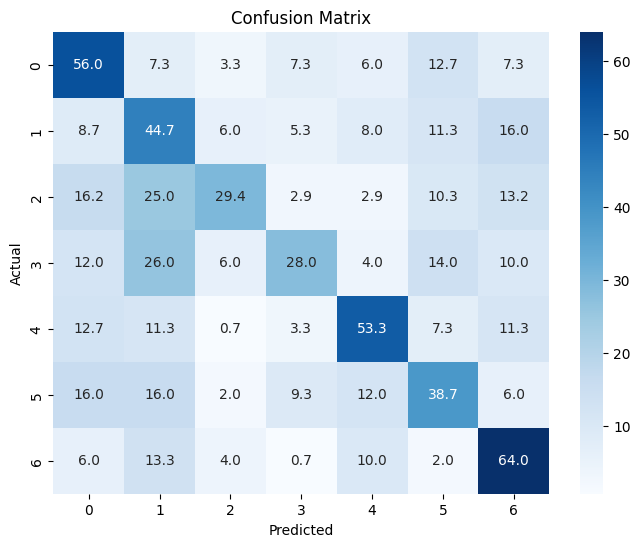

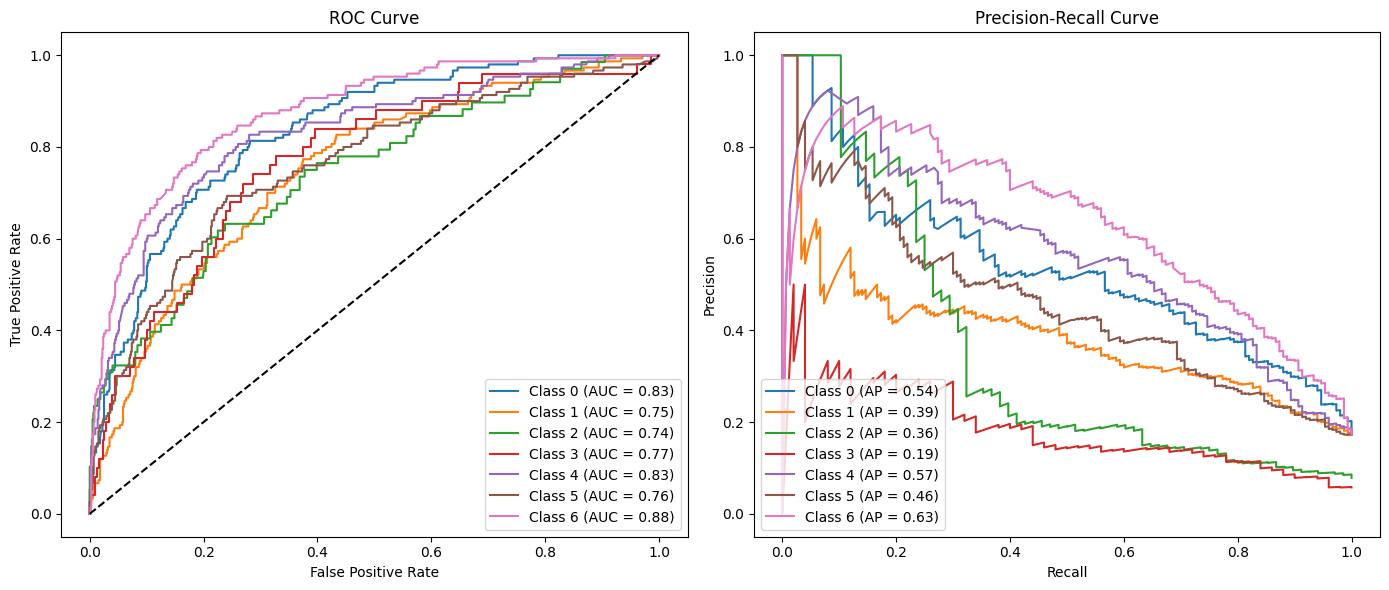

In [10]:
#Validation Phase
model.eval()
test_loss = 0
all_preds, all_labels = [], []
all_probs = []

test_bar = tqdm(test_dataloader, desc="Testing")
with torch.no_grad():
    for batch in test_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = focal_loss(outputs, labels)
        test_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        probs = torch.softmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

#Metrics Evaluation
avg_val_loss = test_loss / len(test_dataloader)
val_accuracy = accuracy_score(all_labels, all_preds)
val_f1 = f1_score(all_labels, all_preds, average="weighted")
val_precision = precision_score(all_labels, all_preds, average="weighted")
val_recall = recall_score(all_labels, all_preds, average="weighted")
val_cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))

print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

cm_normalized = val_cm.astype('float') / val_cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized * 100, annot=True, fmt=".1f", cmap="Blues", xticklabels=list(range(num_classes)), yticklabels=list(range(num_classes)))

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#ROC and PR Curves
all_labels_onehot = np.zeros((len(all_labels), num_classes))
all_labels_onehot[np.arange(len(all_labels)), all_labels] = 1
all_probs = np.array(all_probs)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(all_labels_onehot[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(all_labels_onehot[:, i], all_probs[:, i])
    avg_prec = average_precision_score(all_labels_onehot[:, i], all_probs[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP = {avg_prec:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


Accuracy: 0.99
Precision: 0.66
Recall: 0.84
F1-Score: 0.74


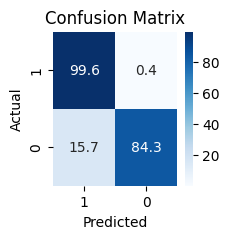

In [14]:
def detect_emotion_flip_with_accuracy(dataset):
    """
    Detect emotion flips in a dataset and evaluate their accuracy.

    Args:
    - dataset (pd.DataFrame): Dataset with columns `Dialogue_ID`, `Utterance`, and `Emotion`.

    Returns:
    - accuracy (float): Accuracy of detected emotion flips compared to actual flips.
    """
    model.eval()
    flip_results = []
    all_actual_flips, all_predicted_flips = [], []

    # Group dataset by Dialogue_ID
    grouped = dataset.groupby("Dialogue_ID")

    for dialogue_id, group in grouped:
        #print(f"Processing Dialogue {dialogue_id}...")

        dialogue_utterances = group["Utterance"].tolist()
        actual_emotions = group["Emotion"].tolist()
        actual_flips = []  # Ground truth flips

        # Detect actual flips based on emotions in the dataset
        prev_emotion = None
        for i, emotion in enumerate(actual_emotions):
            if prev_emotion is not None and emotion != prev_emotion:
                actual_flips.append((i - 1, i))  # Flip indices
            prev_emotion = emotion

        # Predict emotions using the model
        predicted_emotions = []
        prev_predicted_emotion = None
        predicted_flips = []  # Predicted flips

        for utterance_id, utterance in enumerate(dialogue_utterances):
            # Tokenize and prepare input
            inputs = tokenizer(utterance, truncation=True, padding=True, return_tensors="pt").to(device)

            # Predict emotion
            with torch.no_grad():
                logits = model(inputs["input_ids"], inputs["attention_mask"])
                predicted_emotion = torch.argmax(logits, dim=1).item()
                predicted_emotions.append(predicted_emotion)

            # Detect emotion flips
            if prev_predicted_emotion is not None and predicted_emotion != prev_predicted_emotion:
                predicted_flips.append((utterance_id - 1, utterance_id))

            prev_predicted_emotion = predicted_emotion

        # Save flips for this dialogue
        flip_results.append({
            "dialogue_id": dialogue_id,
            "actual_flips": actual_flips,
            "predicted_flips": predicted_flips,
            "actual_count": len(actual_flips),
            "predicted_count": len(predicted_flips),
        })

    return flip_results

#Load the test data again.
#Preparing the Dataset for Task B: Emotion Flip Detection

test_data = pd.read_csv('test_sent_emo.csv', encoding='utf-8')
flip_results = detect_emotion_flip_with_accuracy(test_data)

#Combining all the dialogues into a binary vector representation
all_actual_flips = []
all_predicted_flips = []

#Determining the maximum range of indices across all dialogues
max_index = 0
for dialogue in flip_results:
    flips = dialogue['actual_flips'] + dialogue['predicted_flips']
    if flips:
        max_index = max(max_index, max(max(pair) for pair in flips))

#Generating all possible pairs
possible_pairs = [(i, j) for i in range(max_index + 1) for j in range(i + 1, max_index + 1)]

#Creating binary vectors for each dialogue
for dialogue in flip_results:
    actual_flips = dialogue['actual_flips']
    predicted_flips = dialogue['predicted_flips']
    all_actual_flips.extend([1 if pair in actual_flips else 0 for pair in possible_pairs])
    all_predicted_flips.extend([1 if pair in predicted_flips else 0 for pair in possible_pairs])

#Calculating the metrics
accuracy = accuracy_score(all_actual_flips, all_predicted_flips)
precision = precision_score(all_actual_flips, all_predicted_flips)
recall = recall_score(all_actual_flips, all_predicted_flips)
f1 = f1_score(all_actual_flips, all_predicted_flips)
conf_matrix = confusion_matrix(all_actual_flips, all_predicted_flips)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

cm_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(2, 2))
sns.heatmap(cm_normalized * 100, annot=True, fmt=".1f", cmap="Blues", xticklabels=[1,0], yticklabels=[1,0])

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()